信用卡欺诈
关键词：分类，逻辑回归，交叉验证，混淆矩阵，下采样，过采样

本章练习里，我们需要分析的数据是关于信用卡欺诈的一些数据，因为这些数据会是样本不均衡的，所以我们会采用下采样和过采样的方式进行分析。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# 首先我们查看数据，观察特征分布
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



在数据里我们能注意到一些信息：
1. 最后一列的Class是分类
2. 第一列Time我们不需要关注
3. 倒数第二列的Amount数值过大，相对于其他特征来说，我们需要对这一列特征进行均一化处理

0    284315
1       492
Name: Class, dtype: int64


Text(0, 0.5, 'Class Count')

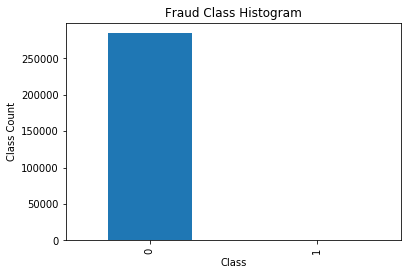

In [3]:
# 既然是分类，让我们先结合图来分析看看数据的分布

# value_counts计算选项个数，返回为series类型
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
print(count_classes)
count_classes.plot(kind = 'bar')
plt.title("Fraud Class Histogram")
plt.xlabel("Class")
plt.ylabel("Class Count")

在上面的直方图里，我们看到正负样本的比例差异很大，样本比例不均衡，接下来我们先进行下采样来学习，然后再进行过采样
我们先把Amount这一列均一化，通过StandardScaler().fit_transform可以把数值均一化成均值0方差1

In [4]:
from sklearn.preprocessing import StandardScaler

# reshape(-1,col) 这里的-1表示很智能计算row = ori_row*ori_col/col
# 如果是reshape(row,-1)则表示智能计算col
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# 删除无用的Time和Amount
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [5]:
# 把Class单独取出成y，非Class的则为特征X
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

# 进行下采样：从分类大的样本中，取出分类小的样本数量的样本

# 统计欺诈的数量，以及欺诈所在的行数
count_fraud = len(data[data.Class == 1])
indices_fraud = np.array(data[data.Class == 1].index)

# 正常交易的行数
indices_normal = np.array(data[data.Class == 0].index)

# random.choice表示从indices_normal这些数字里，选出count_fraud个随机数，replace=False表示不重复选择
random_normal_indices = np.random.choice(indices_normal, count_fraud, replace = False)

# 混合下采样样本集
undersample_indices = np.concatenate([indices_fraud, random_normal_indices])
undersample_data = data.iloc[undersample_indices, :]

X_undersample = undersample_data.loc[:, undersample_data.columns != 'Class']
y_undersample = undersample_data.loc[:, undersample_data.columns == 'Class']

print("Percentage of normal: ", len(undersample_data[undersample_data.Class == 0]) / len(undersample_data))
print("Percentage of fraud: ", len(undersample_data[undersample_data.Class == 1]) / len(undersample_data))
print("Undersample Count: ", len(undersample_data))

Percentage of normal:  0.5
Percentage of fraud:  0.5
Undersample Count:  984


In [6]:
# 使用sklearn的交叉验证工具
from sklearn.model_selection import train_test_split

# test_size代表测试集比例，这里0.3表示30%测试集，70%训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("TrainSet Count: ", len(X_train))
print("TestSet Count: ", len(X_test))
print("Whole DataSet Count: ", len(X))

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size = 0.3, random_state = 0)
print("undersample TrainSet Count: ", len(X_train_undersample))
print("undersample TestSet Count: ", len(X_test_undersample))
print("undersample Count: ", len(X_undersample))

TrainSet Count:  199364
TestSet Count:  85443
Whole DataSet Count:  284807
undersample TrainSet Count:  688
undersample TestSet Count:  296
undersample Count:  984


In [7]:
# 计算recall率：Recall = TP/(TP+FN) 预测正确的正样本占所有真的正样本的比例

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report


In [8]:
def Kfold_scores(x_train_data, y_train_data):
    # 分成5份，shuffle=False表示不进行每次都打乱
    # fold分成2个list：train_indices = indices[0], test_indices = indices[1]
    fold = KFold(5, shuffle = False)
    
    # 逻辑回归
    # 设定惩罚参数
    c_set = [0.01, 0.1, 1, 10, 100]
    
    res = pd.DataFrame(index = range(len(c_set), 2), columns = ['c', 'mean recall'])
    res['c'] = c_set
    
    j = 0
    for c in c_set:
        print("round c: ", c)
        print('')
        
        recall_scores = []
        for iteration, indices in enumerate(fold.split(x_train_data), start = 1):
            
            # 设定逻辑回归函数参数 C为正则化系数λ的倒数，默认为1 penalty可选L1和L2，默认是L2
            lr = LogisticRegression(C = c, penalty = 'l1', solver='liblinear')
            
            # lr.fit() 计算θ，而values是取值，否则会带有index。ravel是变成1维。原来都是[[1],[0]]现在变成[1,0]
            lr.fit(x_train_data.iloc[indices[0], :], y_train_data.iloc[indices[0], :].values.ravel())
            
            # 预测测试集
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1], :].values)
            
            # 用测试集中真实的Class对比，计算recall
            recall = recall_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            recall_scores.append(recall)
            print('Round: ', iteration, ', recall = ', recall)
        
        res.loc[j, 'mean recall'] = np.mean(recall_scores)
        print('mean recall: ', np.mean(recall_scores))
        j += 1
        
    best_c = res.loc[res['mean recall'].values.argmax()]['c']
    print('')
    print('Best c: ', best_c)
    return best_c

In [9]:
# 举例子
d_set = [0.01, 0.1, 1, 10, 100]
res1 = pd.DataFrame(index = range(len(d_set), 2), columns = ['d', 'mean recall'])
print(res1)
res1['d'] = d_set
print("")
print(res1)

Empty DataFrame
Columns: [d, mean recall]
Index: []

        d mean recall
0    0.01         NaN
1    0.10         NaN
2    1.00         NaN
3   10.00         NaN
4  100.00         NaN


In [10]:
best_c = Kfold_scores(X_train_undersample, y_train_undersample)

round c:  0.01

Round:  1 , recall =  0.9315068493150684
Round:  2 , recall =  0.9178082191780822
Round:  3 , recall =  1.0
Round:  4 , recall =  0.9594594594594594
Round:  5 , recall =  0.9696969696969697
mean recall:  0.955694299529916
round c:  0.1

Round:  1 , recall =  0.8493150684931506
Round:  2 , recall =  0.863013698630137
Round:  3 , recall =  0.9152542372881356
Round:  4 , recall =  0.9324324324324325
Round:  5 , recall =  0.8939393939393939
mean recall:  0.89079096615665
round c:  1

Round:  1 , recall =  0.863013698630137
Round:  2 , recall =  0.8767123287671232
Round:  3 , recall =  0.9830508474576272
Round:  4 , recall =  0.9459459459459459
Round:  5 , recall =  0.9242424242424242
mean recall:  0.9185930490086515
round c:  10

Round:  1 , recall =  0.8767123287671232
Round:  2 , recall =  0.8904109589041096
Round:  3 , recall =  0.9830508474576272
Round:  4 , recall =  0.9459459459459459
Round:  5 , recall =  0.9242424242424242
mean recall:  0.924072501063446
round c:  1

In [11]:
# 绘制混淆矩阵
def plot_confusion_mat(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    # imshow是热力图
    # 关于interpolation查阅：https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html?highlight=interpolation
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    

recall metric in undersample test dataset:  0.9319727891156463


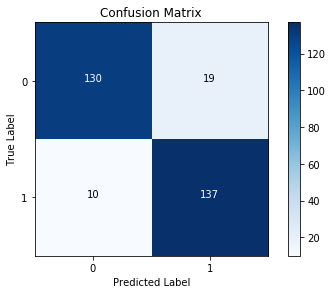

In [12]:
import itertools

# 下采样的样本应用逻辑回归
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())

# 使用下采样样本中的30%测试集预测
y_pred_undersample = lr.predict(X_test_undersample.values)

# 计算混淆矩阵
cnf_mat = confusion_matrix(y_test_undersample, y_pred_undersample)
np.set_printoptions(precision = 2)

print('recall metric in undersample test dataset: ', cnf_mat[1,1] / (cnf_mat[1,0] + cnf_mat[1,1]))

class_names = [0, 1]
plt.figure()
plot_confusion_mat(cnf_mat, classes=class_names, title='Confusion Matrix')
plt.show()

# 下采样训练，下采样预测

recall metric in ALL test dataset:  0.9183673469387755


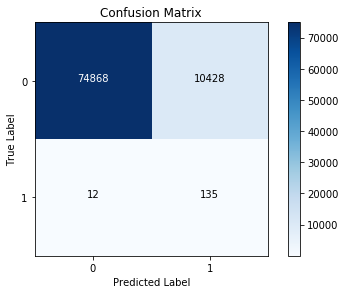

In [13]:
# 下采样的样本应用逻辑回归
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())

# 使用全样本中的30%测试集预测
y_pred = lr.predict(X_test.values)

# 计算混淆矩阵
cnf_mat = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision = 2)

print('recall metric in ALL test dataset: ', cnf_mat[1,1] / (cnf_mat[1,0] + cnf_mat[1,1]))

class_names = [0, 1]
plt.figure()
plot_confusion_mat(cnf_mat, classes=class_names, title='Confusion Matrix')
plt.show()

# 下采样训练，全样本预测

In [14]:
# 上面观测到用下采样训练出来的逻辑回归分类器，运用到所有样本上并不理想，FN高达9159，而FP只有9，被误杀的太多了

# 我们是否能猜测，因为下采样在逻辑回归交叉验证，得初的正则化系数不适用于所有样本直接训练出来的？
# 这次我们来试试直接用所有样本来进行交叉验证
best_c_all = Kfold_scores(X_train,y_train)

round c:  0.01

Round:  1 , recall =  0.4925373134328358
Round:  2 , recall =  0.6027397260273972
Round:  3 , recall =  0.6833333333333333
Round:  4 , recall =  0.5692307692307692
Round:  5 , recall =  0.45
mean recall:  0.5595682284048672
round c:  0.1

Round:  1 , recall =  0.5671641791044776
Round:  2 , recall =  0.6164383561643836
Round:  3 , recall =  0.6833333333333333
Round:  4 , recall =  0.5846153846153846
Round:  5 , recall =  0.525
mean recall:  0.5953102506435158
round c:  1

Round:  1 , recall =  0.5522388059701493
Round:  2 , recall =  0.6164383561643836
Round:  3 , recall =  0.7166666666666667
Round:  4 , recall =  0.6153846153846154
Round:  5 , recall =  0.5625
mean recall:  0.612645688837163
round c:  10

Round:  1 , recall =  0.5522388059701493
Round:  2 , recall =  0.6164383561643836
Round:  3 , recall =  0.7333333333333333
Round:  4 , recall =  0.6153846153846154
Round:  5 , recall =  0.575
mean recall:  0.6184790221704963
round c:  100

Round:  1 , recall =  0.5522

recall metric in ALL test dataset:  0.6190476190476191


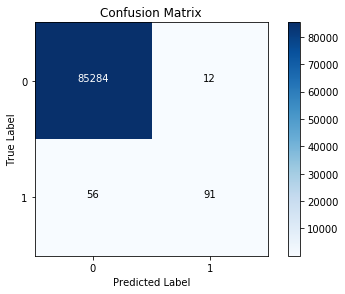

In [15]:
# 上面我们计算出全样本直接训练的C=10，现在把C=10应用到全样本里直接训练和预测
lr = LogisticRegression(C = best_c_all, penalty = 'l1', solver='liblinear')
lr.fit(X_train, y_train.values.ravel())

# 使用全样本中的30%测试集预测
y_pred2 = lr.predict(X_test.values)

# 混淆矩阵
cnf_mat = confusion_matrix(y_test, y_pred2)
np.set_printoptions(precision=2)

print('recall metric in ALL test dataset: ', cnf_mat[1,1] / (cnf_mat[1,0] + cnf_mat[1,1]))

class_names = [0, 1]
plt.figure()
plot_confusion_mat(cnf_mat, classes=class_names, title='Confusion Matrix')
plt.show()

# 全样本训练，全样本预测

recall metric in ALL test dataset:  1.0
recall metric in ALL test dataset:  1.0
recall metric in ALL test dataset:  1.0
recall metric in ALL test dataset:  0.9795918367346939
recall metric in ALL test dataset:  0.9319727891156463
recall metric in ALL test dataset:  0.8639455782312925
recall metric in ALL test dataset:  0.8231292517006803
recall metric in ALL test dataset:  0.7482993197278912
recall metric in ALL test dataset:  0.5986394557823129


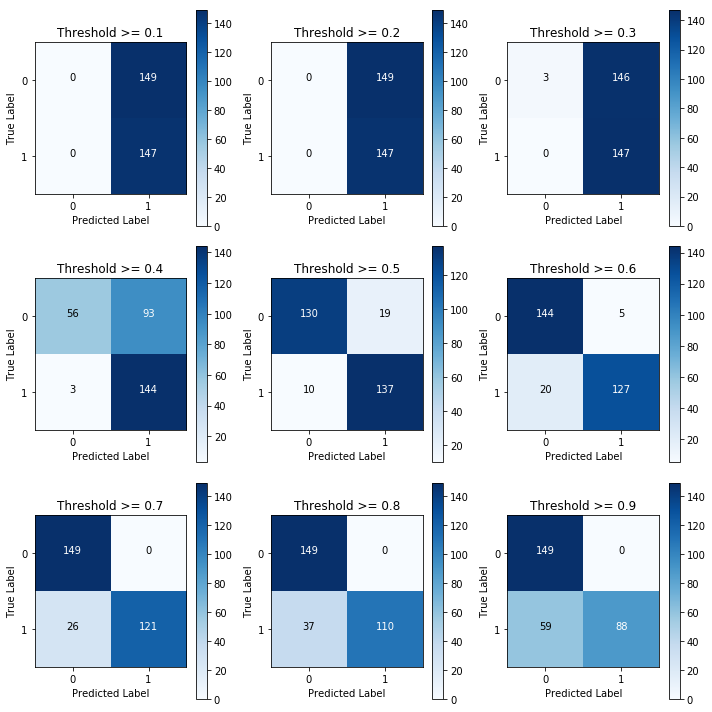

In [16]:
# 在上面我们可以看到recall下降了许多

# 让我们想想，是不是可以通过改变sigmoid分类的划分阈值呢？
# 比如原来默认大于0.5划分为1，小与0.5划分为0，这次让我们看看通过更改阈值会有什么影响

# 这里改回下采样最佳正则化系数
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')

# 使用下采样的样本
lr.fit(X_train_undersample, y_train_undersample.values.ravel())

# 这里我们用的不是predict而是predict_proba，它表示不直接预测出分类，而是每种分类的概率，每行加起来等于1
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

# 设置阈值
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))
j = 1

for i in thresholds:
    # 可能性超过设定阈值的，返回的是true, false，但不是判断真假，而是把【预测1的可能性>阈值】，就判为1
    # 比如说原来是【预测1>0.5】才判为1，现在是只要大于该阈值就通通判为1
    y_test_predictions_high_recall = y_pred_undersample_proba[:, 1] > i
    plt.subplot(3, 3, j)
    j += 1
    
    cnf_mat = confusion_matrix(y_test_undersample, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    
    print('recall metric in ALL test dataset: ', cnf_mat[1,1] / (cnf_mat[1,0] + cnf_mat[1,1]))

    class_names = [0, 1]
    plot_confusion_mat(cnf_mat, classes=class_names, title='Threshold >= %s'%i)


In [17]:
# 在上面我们可以看到根据阈值不同产生的变化，也能从混淆矩阵图中找到最佳的阈值应该是0.5

# 下面我们改用上采样进行训练
from imblearn.over_sampling import SMOTE
# 读取文件
credit_cards = pd.read_csv("creditcard.csv")

# 读取所有列
columns = credit_cards.columns

# 删除标签所在的最后一列，把特征列index[title]赋值到features_columns
features_columns = columns.delete(len(columns) - 1)
print(features_columns)

# 把特征列从原数据集选出来，返回一个DataFrame：features
features = credit_cards[features_columns]

# 把'Class'列赋值到一个DataFrame：labels
labels = credit_cards['Class']

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [18]:
# 训练集80%测试集20%
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=0)
print("train count: ", labels_train.shape[0], "test count: ", labels_test.shape[0])
print("total count: ", labels.shape[0])

train count:  227845 test count:  56962
total count:  284807


In [19]:
# 之前我们得知负样本特别少只有几百个，所有这次我们把负样本进行过采样

# SMOTE过采样：默认把类别不均衡数据，按照1:1生成，使得样本平衡
oversampler = SMOTE(random_state=0)

# 这里我们把原数据集中80%部分的训练集进行过采样，让那20%的测试集保持原样
os_features, os_labels = oversampler.fit_sample(features_train, labels_train)

print("Class 0 before SMOTE: ", len(labels_train[labels_train == 0]))
print("Class 0 after SMOTE: ", len(os_labels[os_labels == 0]))
print("Class 1 before SMOTE: ", len(labels_train[labels_train == 1]))
print("Class 1 after SMOTE: ", len(os_labels[os_labels == 1]))

Class 0 before SMOTE:  227454
Class 0 after SMOTE:  227454
Class 1 before SMOTE:  391
Class 1 after SMOTE:  227454


In [20]:
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)

# 用1:1的过采样样本，去训练逻辑回归里面最好的正则化系数
best_c = Kfold_scores(os_features, os_labels)

round c:  0.01

Round:  1 , recall =  0.8903225806451613
Round:  2 , recall =  0.8947368421052632
Round:  3 , recall =  0.9688834790306518
Round:  4 , recall =  0.957529594091074
Round:  5 , recall =  0.958386915949484
mean recall:  0.9339718823643268
round c:  0.1

Round:  1 , recall =  0.8903225806451613
Round:  2 , recall =  0.8947368421052632
Round:  3 , recall =  0.9704326657076463
Round:  4 , recall =  0.9599696639957793
Round:  5 , recall =  0.9605851771248942
mean recall:  0.9352093859157489
round c:  1

Round:  1 , recall =  0.8903225806451613
Round:  2 , recall =  0.8947368421052632
Round:  3 , recall =  0.9705211906606175
Round:  4 , recall =  0.9603543597014761
Round:  5 , recall =  0.9608709510776975
mean recall:  0.9353611848380432
round c:  10

Round:  1 , recall =  0.8903225806451613
Round:  2 , recall =  0.8947368421052632
Round:  3 , recall =  0.9704105344694036
Round:  4 , recall =  0.9601345335839351
Round:  5 , recall =  0.960958881524714
mean recall:  0.9353126744

recall metric in 20% test dataset:  0.9108910891089109


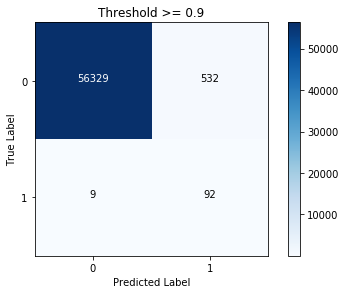

In [21]:
# 过采样中得到的最佳正则化系数
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')

# 运用到过采样样本里去训练逻辑回归分类器
lr.fit(os_features, os_labels.values.ravel())

# 用该过采样分类器去原训练集进行测试
y_pred = lr.predict(features_test.values)

# 计算混淆矩阵
cnf_mat = confusion_matrix(labels_test, y_pred)
np.set_printoptions(precision=2)

print('recall metric in 20% test dataset: ', cnf_mat[1,1] / (cnf_mat[1,0] + cnf_mat[1,1]))

class_names = [0, 1]
plt.figure()
plot_confusion_mat(cnf_mat, classes=class_names, title='Threshold >= %s'%i)
plt.show()

# 过采样训练，全样本预测

在这章练习里，我们学习了在逻辑回归方法里，下采样和过采样对数据的预测和影响，通过不断调参和训练，我们能从中找到最适合分析该数据集的方法。